In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
from torch.utils.data import Dataset
from torch import nn
import torch.nn.functional as F

from fastai.distributed import *
from fastai.vision.all import *

from pathlib import Path
from functools import partial
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


import torchvision.models as models

from PIL import Image
import cv2

import json
from collections import OrderedDict

import ast

In [3]:
device = torch.device('cuda:0')
core_pth = Path('/home/agrawalp2/prepositions'); assert core_pth.exists()
spatialSenses_pth = core_pth/Path('real_world_data/spatialsense'); assert spatialSenses_pth.exists()
stupd_pth = Path('/mnt/dataset/agrawalp2/stupd_dataset'); assert stupd_pth.exists()

In [4]:
#utils
from gensim.models import KeyedVectors
import numpy as np
from autocorrect import Speller

encoder_path = spatialSenses_pth/Path('baselines/GoogleNews-vectors-negative300.bin.gz')
assert encoder_path.exists()
word2vec = KeyedVectors.load_word2vec_format(encoder_path, binary=True, unicode_errors="ignore")

spell = Speller()
def phrase2vec(phrase, max_phrase_len, word_embedding_dim):
    vec = np.zeros((max_phrase_len, word_embedding_dim,), dtype=np.float32)
    for i, word in enumerate(phrase.split()[:max_phrase_len]):
        if word in word2vec: vec[i] = word2vec[word]
        elif spell(word) in word2vec: vec[i] = word2vec[spell(word)]
        else: pass
    return vec


def read_img(url, imagepath):
    if url.startswith("http"):  # flickr
        filename = os.path.join(imagepath, "flickr", url.split("/")[-1])
    else:  # nyu
        filename = os.path.join(imagepath, "nyu", url.split("/")[-1])
    return filename



def noop(x): return x

def convert_stupd_bbox_to_spatialsense_bbox(bbox):
    #stupd bbox format = wmin, hmin, w, h
    #spatialsenses bbox format = hmin, hmax, wmin, wmax
    
    wmin, hmin, w,h = bbox
    return (hmin, hmin+h, wmin, wmin+w)




def is_static(x):
    static_preps = ['above', 'against_leaning', 'all_over', 'along_position', 'among', 'around_static', 
                   'behind', 'below', 'beside', 'between', 'in_front_of', 'inside', 'on', 'outside']
    
    dynamic_preps = ['against', 'along', 'around', 'by', 'down', 'from', 'into', 'into_crash', 'off', 'onto', 'out_of', 'over', 'through', 'towards', 'up', 'with']
    
    if x in static_preps: return True
    elif x in dynamic_preps: return False
    else: raise Exception("invalid relation input")

In [5]:
class stupd(Dataset):
    def __init__(self, 
                 annotations_path = stupd_pth/'annotations', 
                 image_path = stupd_pth/'stupd',
                 x_category_tfms: list = None,
                 y_category_tfms: list = None,
                 x_img_tfms: list = None,
                bbox_mask_tfms = None,
                frames_per_vid=10,
                ):
        
        f'''
        frames_per_vid: how many frames to consider per video for a data sample x. 
                        Per video, frames_per_vid images will be returned, using a sampling. Eg, if sampling = 'uniform', 10 uniformly spaced images will be returned. 
        
        '''
        
        super().__init__()
        self.frames_per_vid = frames_per_vid
        
        assert Path(annotations_path).exists(), f'invalid annotations file path'
        assert Path(image_path).exists(), f'invalid images directory path'
        
        self.subjects = [] #x1: subject classname
        self.objects = [] #x2: object class name
        
        self.subj_bbox = []
        self.obj_bbox = []
        
        self.predicates = [] #y: predicate (preposition) class name
        self.image_fnames = []
        self.classes = set()

        
        #enumerating all raw data objects
        for annotations in annotations_path.iterdir():
            if annotations.suffix!=".csv": continue
#             if annotations.stem not in spatialsenses_to_stupd.values(): continue
            df = self._process_df(pd.read_csv(annotations))
            for i,row in df.iterrows():
     
                subj_3dcoords = eval(row['subject_position3d'])
                obj_3dcoords = eval(row['object_position3d'])
                subj_2dbbox = eval(row['subject_bbox2d'])
                obj_2dbbox = eval(row['object_bbox2d'])
                
                img_pths = eval(row['image_path'])
                
                
                #the below if else conditions are to process the occasional missing values in the coordinate/bbox dictionaries. 
                #And also to bring static and dynamic inputs to same shape. Static images are repeated self.frames_per_vid times to emulate as if it were a static video (instead of an image)
                #if it is dynamic, we first None fill values with empty strings, then sample self.frames_per_vid images from the total 30 frames. 
                    
                if is_static(annotations.stem):
                    if subj_3dcoords is not None and len(subj_3dcoords):
                        s3d, s2dbbox = subj_3dcoords[0], subj_2dbbox[0] 
                    else: 
                        s3d, s2dbbox =  {"x":0, "y":0, "z":0},[0.,0.,0.,0.]
                    
                    if obj_3dcoords is not None and len(obj_3dcoords):
                        o3d, o2dbbox = obj_3dcoords[0], obj_2dbbox[0]  
                    else: 
                        o3d, o2dbbox = {"x":0, "y":0, "z":0},[0.,0.,0.,0.]

                        
                    self.image_fnames.append([image_path/img_pths[0]]*self.frames_per_vid)
                    self.subj_bbox.append([convert_stupd_bbox_to_spatialsense_bbox(s2dbbox) for _ in range(self.frames_per_vid)] )
                    self.obj_bbox.append([convert_stupd_bbox_to_spatialsense_bbox(o2dbbox)  for _ in range(self.frames_per_vid)])
                    
                    
                else:
                    
                    for i in range(len(subj_3dcoords)):
                        if subj_3dcoords[i] is None: subj_3dcoords[i], subj_2dbbox[i] = {"x":0, "y":0, "z":0},[0.,0.,0.,0.]
                        if obj_3dcoords[i] is None:  obj_3dcoords[i],  obj_2dbbox[i] = {"x":0, "y":0, "z":0},[0.,0.,0.,0.]
                   

                    
                    idxs = self._sample(len(img_pths))
                    self.image_fnames.append([image_path/img_pths[i] for i in idxs])
                    self.subj_bbox.append([convert_stupd_bbox_to_spatialsense_bbox(subj_2dbbox[i]) for i in idxs])
                    self.obj_bbox.append([convert_stupd_bbox_to_spatialsense_bbox(obj_2dbbox[i]) for i in idxs])
                    
                        
                self.subjects.append(row['subject_category'] + ' ' + row['subject_supercategory'])
                self.objects.append(row['object_category'] + ' ' + row['object_supercategory'])
                self.predicates.append(annotations.stem)
                self.classes.add(annotations.stem)                
                
                
        self.class2idx = {cat:i for i,cat in enumerate(self.classes)}
        self.idx2class = {self.class2idx[cat]:cat for cat in self.class2idx}
        self.c = len(self.classes)
        
        #transforms
        self.x_category_tfms = list(x_category_tfms or [noop]) 
        self.y_category_tfms = list(y_category_tfms or [noop]) + [lambda y: self.class2idx[y]]
        self.x_img_tfms = list(x_img_tfms or [noop]) + [transforms.ToTensor()]
        self.bbox_mask_tfms = list(bbox_mask_tfms or [noop]) + [transforms.ToTensor()]
        
    
    def __len__(self): return len(self.predicates)
    def __getitem__(self, i):
        #for language part of the model
        subj = self.apply_tfms(self.subjects[i], self.x_category_tfms) 
        obj =  self.apply_tfms( self.objects[i], self.x_category_tfms)
        predicate = self.apply_tfms(self.predicates[i], self.y_category_tfms)
        
        #for computer vision part of the model
        
        bbox_img, bbox_mask = [],[]
        for img,subj_bbox,obj_bbox in zip(self.image_fnames[i], self.subj_bbox[i], self.obj_bbox[i]):
            im = Image.open(img)
            ih, iw = im.shape
            union_bbox = self.enlarge(self._getUnionBBox(subj_bbox,obj_bbox, ih, iw), 1.25, ih, iw)
            bb_img = self.apply_tfms(self._getAppr(np.array(im)[:,:,:3], union_bbox), self.x_img_tfms)
            bb_mask = np.stack([self._getDualMask(ih, iw, subj_bbox , 32).astype(np.uint8),
                              self._getDualMask(ih, iw, obj_bbox , 32).astype(np.uint8),
                              np.zeros((32, 32), dtype=np.uint8)],
                             2)
            bb_mask = self.apply_tfms(bb_mask, self.bbox_mask_tfms)[:2].float() / 255.0
            
            bbox_img.append(bb_img)
            bbox_mask.append(bb_mask)
            
        
        return (torch.Tensor(subj).type(torch.cuda.FloatTensor), 
                torch.Tensor(obj).type(torch.cuda.FloatTensor), 
                torch.cat(bbox_img).type(torch.cuda.FloatTensor),
                torch.cat(bbox_mask).type(torch.cuda.FloatTensor),
                torch.Tensor([predicate]).type(torch.cuda.LongTensor))

    def apply_tfms(self, o, tfms):
        for tfm in tfms: o = tfm(o)
        return o
    
    def enlarge(self, bbox, factor, ih, iw):
        height = bbox[1] - bbox[0]
        width = bbox[3] - bbox[2]
        assert height > 0 and width > 0
        return [
            max(0, int(bbox[0] - (factor - 1.0) * height / 2.0)),
            min(ih, int(bbox[1] + (factor - 1.0) * height / 2.0)),
            max(0, int(bbox[2] - (factor - 1.0) * width / 2.0)),
            min(iw, int(bbox[3] + (factor - 1.0) * width / 2.0)),
        ]

    def _getAppr(self, im, bb, out_size=224.0):
            subim = im[bb[0] : bb[1], bb[2] : bb[3], :]
            subim = cv2.resize(
                subim,
                None,
                None,
                out_size / subim.shape[1],
                out_size / subim.shape[0],
                interpolation=cv2.INTER_LINEAR,
            )
            subim = (subim / 255.0 - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225] #mean and std of imagenet
            return subim.astype(np.float32, copy=False)

    def _getUnionBBox(self, aBB, bBB, ih, iw, margin=10):
            return [max(0, min(aBB[0], bBB[0]) - margin),
                    min(ih, max(aBB[1], bBB[1]) + margin),
                    max(0, min(aBB[2], bBB[2]) - margin),
                    min(iw, max(aBB[3], bBB[3]) + margin)]
        
    def _getDualMask(self, ih, iw, bb, heatmap_size=32):
            rh = float(heatmap_size) / ih
            rw = float(heatmap_size) / iw
            x1 = max(0, int(math.floor(bb[0] * rh)))
            x2 = min(heatmap_size, int(math.ceil(bb[1] * rh)))
            y1 = max(0, int(math.floor(bb[2] * rw)))
            y2 = min(heatmap_size, int(math.ceil(bb[3] * rw)))
            mask = np.zeros((heatmap_size, heatmap_size), dtype=np.float32)
            mask[x1:x2, y1:y2] = 255
            return mask
    
    def _process_df(self, df):
        f"this function replace empty values in subject/object category and supercategory columns with an empty string ('') " 
        cols = ['subject_category', 'subject_supercategory', 'object_category', 'object_supercategory']
        
        df[cols] = df[cols].fillna('')
        return df
    
    def _sample(self, num_frames=30):
        assert num_frames>=self.frames_per_vid, 'not enough values to select from. Reinitialize with reduced frames_per_vid argument'
        
        idxs = [int((i*num_frames -1)/(self.frames_per_vid-1)) for i in range(self.frames_per_vid) ]
        return idxs

In [6]:
max_phrase_len = 3 #subjects/objects can be mutliple words. eg - microwave oven. max_phrase_len decides how many words are used to create embeddings
word_embedding_dim = 300 #decides the dimension of the feature each word is converted into
frames_per_vid = 3

embedding = partial(phrase2vec, max_phrase_len = max_phrase_len, word_embedding_dim = word_embedding_dim)

ds = stupd(
            x_category_tfms = [embedding],
            y_category_tfms = None,
            x_img_tfms =   [transforms.ToPILImage("RGB"),
                            transforms.RandomResizedCrop(224, scale=(0.75, 0.85)),
                            transforms.ColorJitter(0.1, 0.1, 0.1, 0.05)],

            bbox_mask_tfms = [transforms.ToPILImage("RGB"),
                            transforms.Pad(4, padding_mode="edge"),
                            transforms.RandomResizedCrop(32, scale=(0.75, 0.85))],
            
            frames_per_vid = frames_per_vid,
                         )

len(ds)

149776

In [7]:
train_split = 0.8
train_ds, valid_ds = torch.utils.data.random_split(ds, [int(len(ds)*train_split), len(ds) - int(len(ds)*train_split)])
train_ds.c, valid_ds.c = ds.c, ds.c

len(train_ds), len(valid_ds)

(119820, 29956)

In [8]:
train_dl = DataLoader(train_ds, batch_size =512 , shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = 512 , shuffle = False)

# Model

In [9]:
#helper models
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, in_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=1)
        self.layernorm1 = nn.LayerNorm((out_channels // 2, in_size, in_size))
        self.conv2 = nn.Conv2d(
            out_channels // 2, out_channels // 2, kernel_size=3, padding=1
        )
        self.layernorm2 = nn.LayerNorm((out_channels // 2, in_size, in_size))
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=1)
        self.conv_skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, inp):
        x = F.relu(self.layernorm1(self.conv1(inp)))
        x = F.relu(self.layernorm2(self.conv2(x)))
        x = self.conv3(x)
        return x + self.conv_skip(inp)

class Hourglass(nn.Module):
    def __init__(self, im_size, feature_dim):
        super().__init__()
        assert im_size == 1 or im_size % 2 == 0
        self.skip_resblock = ResidualBlock(feature_dim, feature_dim, im_size)
        if im_size > 1:
            self.pre_resblock = ResidualBlock(feature_dim, feature_dim, im_size // 2)
            self.layernorm1 = nn.LayerNorm((feature_dim, im_size // 2, im_size // 2))
            self.sub_hourglass = Hourglass(im_size // 2, feature_dim)
            self.layernorm2 = nn.LayerNorm((feature_dim, im_size // 2, im_size // 2))
            self.post_resblock = ResidualBlock(feature_dim, feature_dim, im_size // 2)

    def forward(self, x):
        up = self.skip_resblock(x)
        if x.size(-1) == 1:
            return up
        down = F.max_pool2d(x, 2)
        down = F.relu(self.layernorm1(self.pre_resblock(down)))
        down = F.relu(self.layernorm2(self.sub_hourglass(down)))
        down = self.post_resblock(down)
        down = F.upsample(down, scale_factor=2)
        return up + down

    
    
class PhraseEncoder(nn.Module):
    def __init__(self, word_embedding_dim, num_layers = 1, batch_first = True, bidirectional = True):
        super().__init__()
        self.encoder = nn.GRU(input_size = word_embedding_dim, 
                                     hidden_size = word_embedding_dim//2,
                                     num_layers = num_layers,
                                     batch_first = batch_first,
                                     bidirectional = bidirectional,
                                    )
    def forward(self, x): return torch.squeeze(self.encoder(x)[0][:,-1,:])
    
class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.linear = nn.Linear(input_dim, output_dim)
        self.batchnorm = nn.BatchNorm1d(output_dim)
        self.ReLU = nn.ReLU()
        
    def forward(self, x):
        x = self.linear(x)
        x = self.batchnorm(x)
        x = self.ReLU(x)
        return x
    

In [10]:
class DRNet(nn.Module):
    def __init__(self, phrase_encoder, feature_dim, num_classes, num_layers=3, frames_per_vid = 10, backbone='resnet18'):
        super(DRNet, self).__init__()
        
        self.frames_per_vid = frames_per_vid
        
        self.phrase_encoder =  phrase_encoder
        self.feature_dim = feature_dim
        
        self.appr_module = models.__dict__[backbone](pretrained=True)
#         self.appr_module = backbone(pretrained = True)
        self.appr_module.conv1 = nn.Conv2d(3*self.frames_per_vid, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.appr_module.fc = nn.Linear(512, feature_dim//2)
        
        self.num_layers = num_layers
        self.c = num_classes
        
        

        self.pos_module = nn.Sequential(
            OrderedDict(
                [
                    ("conv1_p", nn.Conv2d(2*self.frames_per_vid, 32, 5, 2, 2)),
                    ("batchnorm1_p", nn.BatchNorm2d(32)),
                    ("relu1_p", nn.ReLU()),
                    ("conv2_p", nn.Conv2d(32, 64, 3, 1, 1)),
                    ("batchnorm2_p", nn.BatchNorm2d(64)),
                    ("relu2_p", nn.ReLU()),
                    ("maxpool2_p", nn.MaxPool2d(2)),
                    ("hg", Hourglass(8, 64)),
                    ("batchnorm_p", nn.BatchNorm2d(64)),
                    ("relu_p", nn.ReLU()),
                    ("maxpool_p", nn.MaxPool2d(2)),
                    ("conv3_p", nn.Conv2d(64, feature_dim//2, 4)),
                    ("batchnorm3_p", nn.BatchNorm2d(feature_dim//2)),
                ]
            )
        )

#         self.PhiR_0 = nn.Linear(512, feature_dim)
        self.batchnorm = nn.BatchNorm1d(feature_dim)
        self.Phi_subj = nn.Linear(300, feature_dim//2)
        self.Phi_obj = nn.Linear(300, feature_dim//2)
#         self.PhiR = nn.Linear(feature_dim, feature_dim)

#         self.fc = nn.Linear(feature_dim, 9)
        self.fc = nn.Sequential(LinearBlock(2*feature_dim,feature_dim), 
                                LinearBlock(feature_dim, feature_dim//2), 
                                nn.Linear(feature_dim//2, self.c))

    def forward(self, subj, obj, im, posdata):
        appr_feature = self.appr_module(im) #output 256 features
        pos_feature = (self.pos_module(posdata).view(-1, self.feature_dim//2))#output 256 features
        
        
        qa = self.phrase_encoder(subj)
        qb = self.phrase_encoder(obj)
        
        x = torch.cat([appr_feature, 
                       pos_feature,
                       self.Phi_subj(qa), self.Phi_obj(qb),
                      ], 1)

        x = self.fc(x)
        return x

In [11]:
dls = DataLoaders(train_dl, valid_dl)
dls.n_inp = 4

phrase_encoder = PhraseEncoder(300)
model = DRNet(phrase_encoder, 512, train_ds.c, frames_per_vid = frames_per_vid).cuda()

learn = Learner(dls, model = model, loss_func = CrossEntropyLossFlat(), metrics = [accuracy,BalancedAccuracy()])

In [12]:
model

DRNet(
  (phrase_encoder): PhraseEncoder(
    (encoder): GRU(300, 150, batch_first=True, bidirectional=True)
  )
  (appr_module): ResNet(
    (conv1): Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [29]:
learn.fit_one_cycle(5, 1.5e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time


KeyboardInterrupt: 

In [30]:
learn.recorder.values

[]

In [31]:
learn.save(core_pth/'experiments/overall training on stupd/models/drnet_stupd_only.pkl')

Path('/home/agrawalp2/prepositions/experiments/overall training on stupd/models/drnet_stupd_only.pkl.pth')

In [22]:
corrects = [0]*ds.c
total = [0]*ds.c

accs = {}



corrects_relation_super = [0]*2
total_relation_super = [0]*2

accs_relation_super = [0]*2


for i,(a,b,c,d,e) in enumerate(valid_dl):
    print(i, end = ' ')
#     res = torch.argmax(model(a,b))
    res = torch.argmax(model(a,b,c,d), dim = 1, keepdim=False)
    
    for gt,r in zip(e, res): 
        total[gt]+=1
        corrects[gt]+=(int(gt==r))
        
        total_relation_super[is_static(ds.idx2class[gt.item()])]+=1
        corrects_relation_super[is_static(ds.idx2class[gt.item()])]+=(int(gt==r))
    break
    
    
for i in range(len(corrects)):
    accs[ds.idx2class[i]]=corrects[i]/total[i]
for i in range(len(corrects_relation_super)):
    accs_relation_super[i]=corrects_relation_super[i]/total_relation_super[i]
    

0 

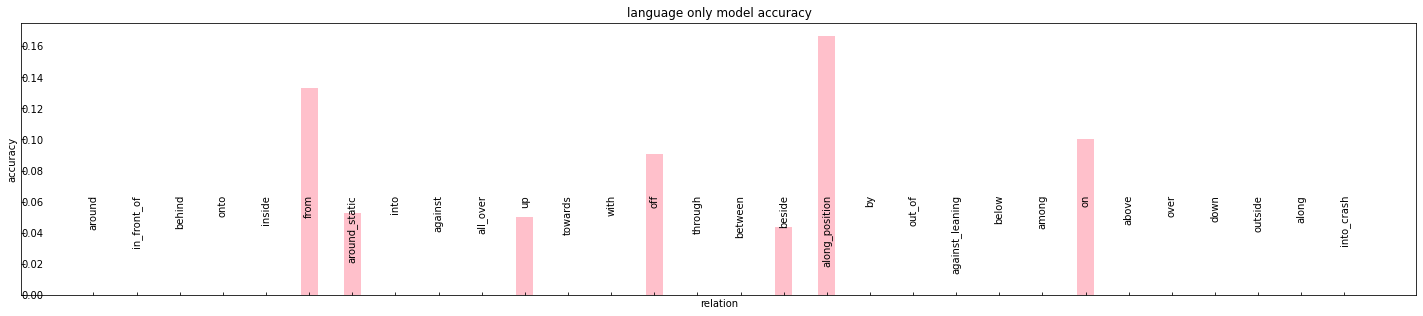

{'around': 0.0, 'in_front_of': 0.0, 'behind': 0.0, 'onto': 0.0, 'inside': 0.0, 'from': 0.13333333333333333, 'around_static': 0.05263157894736842, 'into': 0.0, 'against': 0.0, 'all_over': 0.0, 'up': 0.05, 'towards': 0.0, 'with': 0.0, 'off': 0.09090909090909091, 'through': 0.0, 'between': 0.0, 'beside': 0.043478260869565216, 'along_position': 0.16666666666666666, 'by': 0.0, 'out_of': 0.0, 'against_leaning': 0.0, 'below': 0.0, 'among': 0.0, 'on': 0.1, 'above': 0.0, 'over': 0.0, 'down': 0.0, 'outside': 0.0, 'along': 0.0, 'into_crash': 0.0}


In [23]:
fig = plt.figure(figsize = (25, 5))
 
# creating the bar plot
plt.bar(accs.keys(), accs.values(),
        width = 0.4, color='pink')
 
plt.xlabel("relation")
plt.xticks(rotation = 90)
plt.ylabel("accuracy")
plt.title("language only model accuracy")

plt.tick_params(axis="y",direction="in", pad=-22)
plt.tick_params(axis="x",direction="in", pad=-100)
plt.savefig(core_pth/'experiments/overall training on stupd/drnet_offline_training/class_wise_accuracy.png')
plt.show()


print(accs)

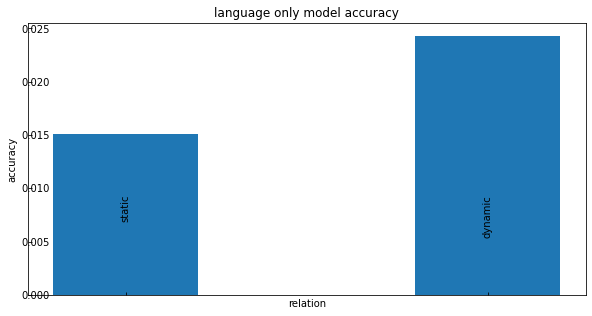

static_accuracy 0.01509433962264151
dynamic_accuracy 0.024291497975708502
0.01999949074427724


In [25]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(['static', 'dynamic'], accs_relation_super,
        width = 0.4)
 
plt.xlabel("relation")
plt.xticks(rotation = 90)
plt.ylabel("accuracy")
plt.title("language only model accuracy")

plt.tick_params(axis="y",direction="in", pad=-22)
plt.tick_params(axis="x",direction="in", pad=-100)

plt.savefig(core_pth/'experiments/overall training on stupd/drnet_offline_training/static_vs_dynamic_accuracy.png')

plt.show()


print('static_accuracy', accs_relation_super[0])
print('dynamic_accuracy', accs_relation_super[1])

print(accs_relation_super[1]*16/30 + accs_relation_super[0]*14/30)